# Project_Break_II_ML

# Flights Delay Prediction

<img src="src/img/openart_image_1_1.jpg" width="1200"/>


This work aims to use a dataset on flights, geolocation, and meteorological indicators to predict possible delays. The dataset used was obtained from the following Kaggle page: https://www.kaggle.com/datasets/bordanova/2023-us-civil-flights-delay-meteo-and-aircraft/data

## General Objectives:
- (1) Prediction of whether a flight will be delayed at takeoff;
- (2) Prediction of the arrival time at the destination airport;

## Specific Objectives:
- (1) A binary classifier to classify delayed flights (class 1) and on-time flights (class 0) within a 15-minute tolerance beyond the scheduled time. For this objective, only logistical data available since the flight booking and weather forecasts will be used, without real-time updates immediately before takeoff. This makes the classifier very challenging but provides a highly important predictive potential, as it helps identify delay patterns that are independent of unpredictable, stochastic, and uncontrollable events;

- (2) Prediction of the arrival time at the destination airport once the actual takeoff time is known.


-------------------------------

# Objective 2: *Arrival Delay Regression*

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_columns', None)

Importing Personalized Tools

In [3]:
import sys
import os

sys.path.append(os.path.abspath('src'))

from utils.User_Functions import *

In [4]:
try_GPU()

Using GPU


Importing Datasets

In [5]:
df_flights = pd.read_csv("./src/data/US_flights_2023.csv")
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6743404 entries, 0 to 6743403
Data columns (total 24 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   FlightDate          object
 1   Day_Of_Week         int64 
 2   Airline             object
 3   Tail_Number         object
 4   Dep_Airport         object
 5   Dep_CityName        object
 6   DepTime_label       object
 7   Dep_Delay           int64 
 8   Dep_Delay_Tag       int64 
 9   Dep_Delay_Type      object
 10  Arr_Airport         object
 11  Arr_CityName        object
 12  Arr_Delay           int64 
 13  Arr_Delay_Type      object
 14  Flight_Duration     int64 
 15  Distance_type       object
 16  Delay_Carrier       int64 
 17  Delay_Weather       int64 
 18  Delay_NAS           int64 
 19  Delay_Security      int64 
 20  Delay_LastAircraft  int64 
 21  Manufacturer        object
 22  Model               object
 23  Aicraft_age         int64 
dtypes: int64(11), object(13)
memory usage: 1.2+ GB


In [6]:
df_weather = pd.read_csv("./src/data/weather_meteo_by_airport.csv")
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132860 entries, 0 to 132859
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        132860 non-null  object 
 1   tavg        132860 non-null  float64
 2   tmin        132860 non-null  float64
 3   tmax        132860 non-null  float64
 4   prcp        132860 non-null  float64
 5   snow        132860 non-null  float64
 6   wdir        132860 non-null  float64
 7   wspd        132860 non-null  float64
 8   pres        132860 non-null  float64
 9   airport_id  132860 non-null  object 
dtypes: float64(8), object(2)
memory usage: 10.1+ MB


In [7]:
df_location = pd.read_csv("./src/data/airports_geolocation.csv")
df_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  364 non-null    object 
 1   AIRPORT    364 non-null    object 
 2   CITY       364 non-null    object 
 3   STATE      364 non-null    object 
 4   COUNTRY    364 non-null    object 
 5   LATITUDE   364 non-null    float64
 6   LONGITUDE  364 non-null    float64
dtypes: float64(2), object(5)
memory usage: 20.0+ KB


Merging Datasets

In [8]:
# Converting FlightDate and time to datetime
df_flights['FlightDate'] = pd.to_datetime(df_flights['FlightDate'], errors='coerce')
df_weather['time'] = pd.to_datetime(df_weather['time'], errors='coerce')

# Merging DataFrames df_flights, df_location, df_weather
merged_df = pd.merge(df_flights, df_location,
                    how='left',
                    left_on=['Dep_Airport'],
                    right_on=['IATA_CODE'])

merged_df = pd.merge(merged_df, df_weather,
                      how='left',
                      left_on=['Dep_Airport', 'FlightDate'],
                      right_on=['airport_id', 'time'])


In [9]:
merged_df.sample(3)

,FlightDate,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,Arr_Airport,Arr_CityName,Arr_Delay,Arr_Delay_Type,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,airport_id
2906267,2023-06-10,6,Delta Air Lines Inc,N514DE,JFK,"New York, NY",Morning,-5,0,Low <5min,LAS,"Las Vegas, NV",-30,Low <5min,312,Medium Haul <3000Mi,0,0,0,0,0,AIRBUS,A321,2,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893,2023-06-10,18.6,13.3,26.7,0.8,0.0,288.0,16.9,1008.7,JFK
1487879,2023-03-16,4,American Airlines Inc.,N809NN,DFW,"Dallas/Fort Worth, TX",Afternoon,29,1,Medium >15min,ORD,"Chicago, IL",21,Medium >15min,131,Short Haul >1500Mi,5,0,0,0,16,BOEING,737 NG,15,DFW,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,USA,32.89595,-97.03720,2023-03-16,18.1,6.7,21.7,24.1,0.0,180.0,34.6,1008.8,DFW
373932,2023-01-25,3,Southwest Airlines Co.,N8739L,LAX,"Los Angeles, CA",Evening,-4,0,Low <5min,LAS,"Las Vegas, NV",-8,Low <5min,61,Short Haul >1500Mi,0,0,0,0,0,BOEING,737 NG,5,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,2023-01-25,12.4,6.1,20.6,0.0,0.0,341.0,6.8,1024.6,LAX


| Field               | Description                                               | Example                               |
|---------------------|-----------------------------------------------------------|---------------------------------------|
| FlightDate         | The date of the flight.                                    | 2024-09-09                           |
| Day_Of_Week        | The day of the week when the flight occurred.              | Monday                               |
| Airline           | The name or code of the airline operating the flight.      | AA for American Airlines             |
| Tail_Number       | The unique identifier (registration number) of the aircraft. | N123AA                               |
| Dep_Airport       | The IATA code of the departure airport.                    | JFK                                  |
| Dep_CityName      | The name of the city where the departure airport is located. | New York                             |
| DepTime_label     | The categorized or labeled departure time.                 | Morning                              |
| Dep_Delay        | The number of minutes the flight was delayed at departure.  | 1                                   |
| Dep_Delay_Tag    | Categorical representation of the departure delay.          | On-time                              |
| Dep_Delay_Type   | The type or reason for the departure delay.                 | Operational                          |
| Arr_Airport      | The IATA code of the arrival airport.                       | LAX                                  |
| Arr_CityName     | The name of the city where the arrival airport is located.  | Los Angeles                          |
| Arr_Delay       | The number of minutes the flight was delayed at arrival.     | 10                                   |
| Arr_Delay_Type  | The type or reason for the arrival delay.                    | Weather                              |
| Flight_Duration | The duration of the flight.                                  | 300 minutes                          |
| Distance_type   | The classification of flight distance.                       | Long-haul                            |
| Delay_Carrier   | The number of minutes the delay is attributed to the airline/carrier. | 5                          |
| Delay_Weather   | The number of minutes the delay is attributed to weather conditions. | 10                         |
| Delay_NAS       | The number of minutes the delay is attributed to National Airspace System issues. | 0 |
| Delay_Security  | The number of minutes the delay is attributed to security-related issues. | 0 |
| Delay_LastAircraft | The number of minutes the delay is attributed to delays in the aircraft's previous flight. | 20 |
| Manufacturer    | The company that manufactured the aircraft.                   | Boeing                               |
| Model          | The model of the aircraft.                                     | Boeing 737                           |
| Aircraft_age   | The age of the aircraft in years.                             | 12 years                             |
| time           | The specific time or timestamp associated with the flight record. | 12:30 PM                         |
| tavg           | The average temperature on the day of the flight.             | 22°C                                 |
| tmin           | The minimum temperature on the day of the flight.             | 18°C                                 |
| tmax           | The maximum temperature on the day of the flight.             | 28°C                                 |
| prcp           | The amount of precipitation on the day of the flight.         | 2 mm                                 |
| snow           | The amount of snowfall on the day of the flight.              | 0 mm                                 |
| wdir           | The wind direction.                                           | 270°                                 |
| wspd           | The wind speed.                                               | 15 km/h                              |
| pres           | The atmospheric pressure.                                     | 1015 hPa                             |
| airport_id     | A unique identifier for the airport.                          | 12345                                |
| IATA_CODE      | The International Air Transport Association code for the airport. | JFK                            |
| AIRPORT        | The name of the airport.                                      | John F. Kennedy International Airport |
| CITY           | The city where the airport is located.                        | New York                             |
| STATE          | The state or region where the airport is located.             | NY                                   |
| COUNTRY        | The country where the airport is located.                     | USA                                  |
| LATITUDE       | The latitude coordinate of the airport.                       | 40.6413° N                           |
| LONGITUDE      | The longitude coordinate of the airport.                      | 73.7781° W                           |


In [10]:
# Dropping redundant and unnecessary columns
merged_df.drop(columns=["IATA_CODE", "AIRPORT", "CITY", "STATE", "COUNTRY", "time", "airport_id"], inplace=True)

In [11]:
# Splitting FlightDate into Day and Month columns
merged_df['Month'] = merged_df['FlightDate'].dt.month
merged_df['Day'] = merged_df['FlightDate'].dt.day
merged_df.drop(columns=["FlightDate"], inplace=True)
merged_df.sample(2)


,Day_Of_Week,Airline,Tail_Number,Dep_Airport,Dep_CityName,DepTime_label,Dep_Delay,Dep_Delay_Tag,Dep_Delay_Type,Arr_Airport,Arr_CityName,Arr_Delay,Arr_Delay_Type,Flight_Duration,Distance_type,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Manufacturer,Model,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day
695263,6,Delta Air Lines Inc,N376NW,DTW,"Detroit, MI",Afternoon,69,1,Hight >60min,MSP,"Minneapolis, MN",48,Medium >15min,102,Short Haul >1500Mi,48,0,0,0,0,AIRBUS,A320,22,42.21206,-83.34884,-1.7,-6.1,2.2,1.5,30.0,211.0,12.7,1024.3,2,25
1505637,4,American Airlines Inc.,N849NN,CLT,"Charlotte, NC",Afternoon,-7,0,Low <5min,MCI,"Kansas City, MO",-18,Low <5min,140,Short Haul >1500Mi,0,0,0,0,0,BOEING,737 NG,14,35.21401,-80.94313,9.2,-1.0,20.0,0.0,0.0,194.0,11.9,1021.0,3,16


#### Analysing merged_df data

The function ```type_variables``` below analyzes the nature of the data in each column and classifies them as numerical, categorical, and "ID-like" features, which are categorical features represented as numbers.

In [12]:
features_num, features_cat, features_id = type_features(merged_df)

print("Numerical features:", features_num)
print("Categorical features:", features_cat)
print("ID features (numeric categoricals):", features_id)

Numerical features: ['Day_Of_Week', 'Dep_Delay', 'Dep_Delay_Tag', 'Arr_Delay', 'Flight_Duration', 'Delay_Carrier', 'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft', 'Aicraft_age', 'LATITUDE', 'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'Month', 'Day']
Categorical features: ['Airline', 'Tail_Number', 'Dep_Airport', 'Dep_CityName', 'DepTime_label', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay_Type', 'Distance_type', 'Manufacturer', 'Model']
ID features (numeric categoricals): []


Select all logistic, climatic, and departure features.

In [13]:
# All numeric features
features_num = [col for col in merged_df.columns if merged_df[col].dtype in ['int64', 'float64']]

# Excluding Arr_Delay_Type
features_cat = ["Airline", "Tail_Number", "Dep_Airport", "DepTime_label", "Arr_Airport", "Distance_type", 
                "Manufacturer", "Model"]

features_id = []

Declaring target for regression of Arrival Delay

In [14]:
target_reg = "Arr_Delay"

In [15]:
# Counting nulls
df = merged_df[features_num + features_cat + [target_reg]].copy()
df.isnull().sum()

Day_Of_Week           0
Dep_Delay             0
Dep_Delay_Tag         0
Arr_Delay             0
Flight_Duration       0
Delay_Carrier         0
Delay_Weather         0
Delay_NAS             0
Delay_Security        0
Delay_LastAircraft    0
Aicraft_age           0
LATITUDE              0
LONGITUDE             0
tavg                  0
tmin                  0
tmax                  0
prcp                  0
snow                  0
wdir                  0
wspd                  0
pres                  0
Airline               0
Tail_Number           0
Dep_Airport           0
DepTime_label         0
Arr_Airport           0
Distance_type         0
Manufacturer          0
Model                 0
Arr_Delay             0
dtype: int64

In [16]:
print("Number of duplicates in df:", df.duplicated().sum())
df.loc[df.duplicated()].sample(2)

Number of duplicates in df: 31


,Day_Of_Week,Dep_Delay,Dep_Delay_Tag,Arr_Delay,Flight_Duration,Delay_Carrier,Delay_Weather,Delay_NAS,Delay_Security,Delay_LastAircraft,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Airline,Tail_Number,Dep_Airport,DepTime_label,Arr_Airport,Distance_type,Manufacturer,Model,Arr_Delay
6415478,2,-6,0,-15,83,0,0,0,0,0,8,27.54374,-99.46154,15.1,9.4,20.0,0.0,0.0,93.0,11.2,1023.3,American Eagle Airlines Inc.,N233NN,LRD,Morning,DFW,Short Haul >1500Mi,EMBRAER,170/175,-15
3603302,1,-2,0,-7,55,0,0,0,0,0,5,21.31869,-157.92241,27.7,25.0,31.1,0.0,0.0,62.0,25.6,1018.3,Southwest Airlines Co.,N8741L,HNL,Morning,ITO,Short Haul >1500Mi,BOEING,737 NG,-7


In [17]:
df.drop_duplicates(inplace=True, keep='first')

Randomly reducing the dataset to 10% size for computational performance during the following modeling processes

In [18]:
from sklearn.utils import resample

# Random subsampling
data_sample = resample(df, replace=False, n_samples=int(len(df) * 0.10), random_state=42)

print("Original Dataset size:", len(df))
print("Dataset size after subsampling:", len(data_sample))

Original Dataset size: 6743373
Dataset size after subsampling: 674337


Dividing train and test set

In [19]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data_sample, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_set.shape)

(539469, 30)
(134868, 30)


### Detecting Outliers

In [20]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(train_set[features_num])  # Only on original numerical features

train_set_clean = train_set[outliers == 1].copy()  # Remove detected outliers

# Now you can transform the numerical features of train_set_clean

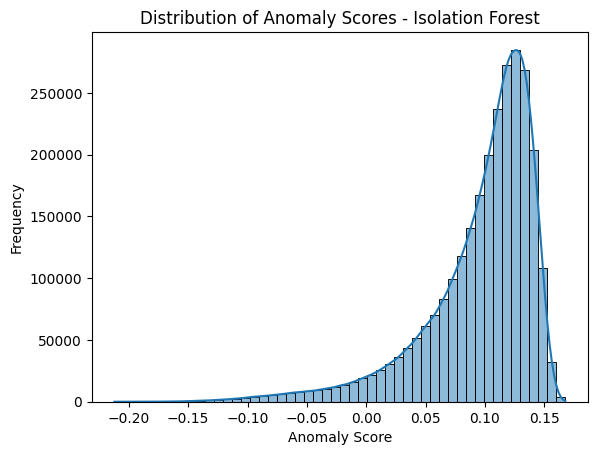

In [21]:
# Get anomaly scores
anomaly_scores = iso_forest.decision_function(train_set[features_num])

# Plot anomaly score distribution
sns.histplot(anomaly_scores, bins=50, kde=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores - Isolation Forest")
plt.show()


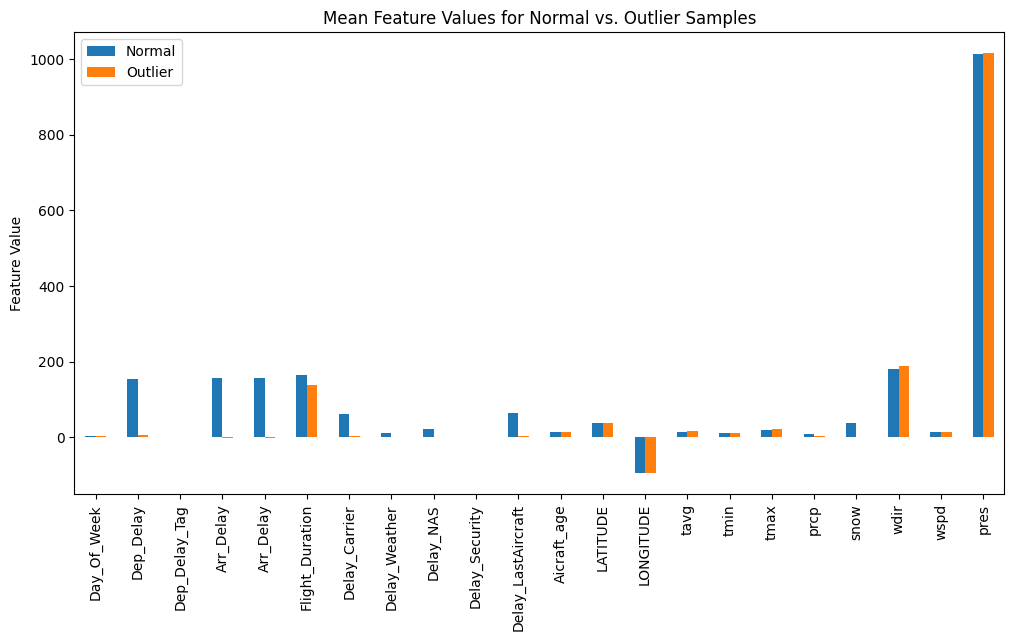

In [22]:
# Add outlier labels (1 = normal, -1 = outlier)
train_set["outlier"] = outliers

# Compute mean feature values for normal vs. outlier samples
feature_impact = train_set.groupby("outlier")[features_num].mean().T
feature_impact.columns = ["Normal", "Outlier"]

# Plot feature differences
feature_impact.plot(kind="bar", figsize=(12,6))
plt.title("Mean Feature Values for Normal vs. Outlier Samples")
plt.ylabel("Feature Value")
plt.show()


In [23]:
print("Nmber of identified outliers:", len(train_set) - len(train_set_clean), "out of", len(train_set_clean))
print("Percentage of outliers:", round(((len(train_set) - len(train_set_clean)) * 100) / len(train_set), 4), "%")


Nmber of identified outliers: 134868 out of 2562480
Percentage of outliers: 5.0 %


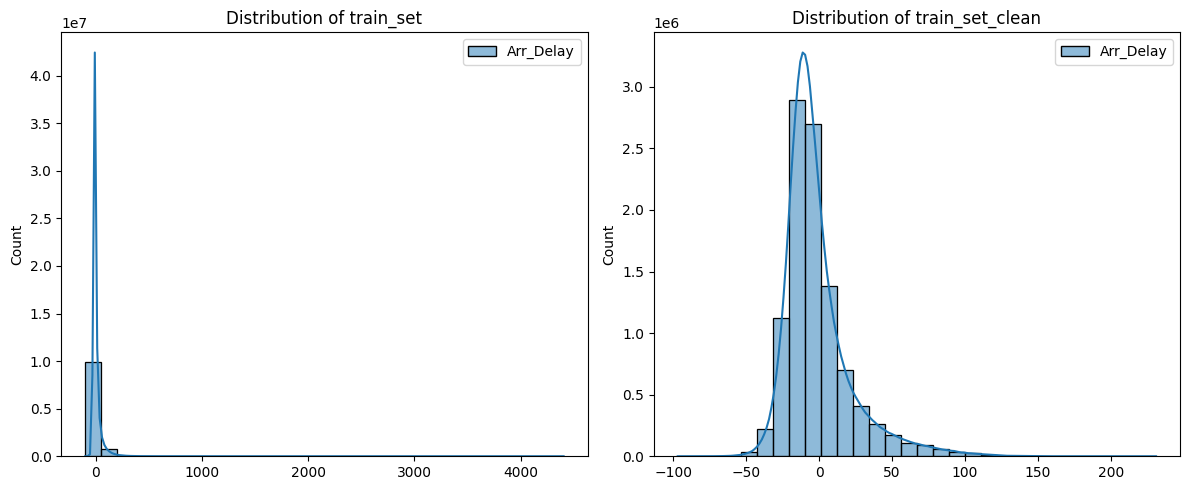

In [24]:
# Set figure size
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of the original dataset
sns.histplot(train_set[target_reg], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of train_set")

# Histogram of the cleaned dataset
sns.histplot(train_set_clean[target_reg], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of train_set_clean")

# Adjust layout and display plots
plt.tight_layout()
plt.show()

The above graphs allow us to visualize how removing outliers makes the target distribution less skewed and slightly closer to a normal distribution.

In [25]:
outliers_test = iso_forest.predict(test_set[features_num])

test_set_clean = test_set[outliers_test == 1].copy()  # Remove detected outliers from test_set

print("Percentage of outliers in test set:", round((len(test_set) - len(test_set_clean)) * 100 / len(test_set),4), "%")


Percentage of outliers in test set: 5.0467 %


### Target Encoding with K-Fold

The **`target_encoding_kfold_regression`** function applies **Target Encoding** with **K-Fold Cross Validation** to prevent **data leakage** during training, ensuring the model only learns from training data.

---

#### Key Steps:

1. **K-Fold Validation**:
   - Splits the training data into **n_splits** (default 5) using **StratifiedKFold** to ensure balanced target distribution.
   - Prevents **data leakage** by ensuring encoding is only based on training data.

2. **Resetting Indices**:
   - Resets indices in both train and validation sets to avoid **index misalignment** when applying target encoding.

3. **Smoothing**:
   - Calculates the category mean with a smoothing technique that combines the category mean with the global mean to handle sparse categories.

4. **Mapping and Handling Unseen Categories**:
   - Categories in validation and test sets are **mapped** to the calculated target mean; missing categories are assigned the **global mean** to avoid errors.

---

#### Why K-Fold?

- **K-Fold** ensures that encoding is done only with training data, preventing future data from contaminating the model and causing **data leakage**.

---

This approach guarantees **robust target encoding**, preserves model integrity, and prevents **overfitting**.


The following cell counts how many categorical values exist in the test set but not in the train set. High values may indicate issues for target encoding strategy, as unseen values in the test set will be assigned the global mean.

In [21]:
# Check non correspondenting values in test set/train set
non_correspondence = {col: {'unique': [], 'absolute': [], 'total_percentage': []} for col in features_cat}

# Iterate over the categorical columns
for col in features_cat:
    # Identify unique values in test_set that are not in train_set
    test_values = set(test_set[col])
    train_values = set(train_set[col])
    
    # Values in test_set but not in train_set
    non_matching_values = test_values - train_values
    
    # Count the number of unique values and the absolute count of these values
    non_correspondence[col]['unique'] = len(non_matching_values)
    non_correspondence[col]['absolute'] = sum(test_set[col].isin(non_matching_values))
    non_correspondence[col]['total_percentage'] = (len(non_matching_values) * 100) / len(test_set)
    
# Convert the dictionary to a DataFrame
non_correspondence_df = pd.DataFrame(non_correspondence)
non_correspondence_df



,Airline,Tail_Number,Dep_Airport,DepTime_label,Arr_Airport,Distance_type,Manufacturer,Model
unique,0.0,15.000000,0.0,0.0,0.0,0.0,0.0,0.0
absolute,0.0,20.000000,0.0,0.0,0.0,0.0,0.0,0.0
total_percentage,0.0,0.011122,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
from sklearn.model_selection import KFold

def target_encoding_kfold_regressionk(train_set, test_set, categorical_features, target, n_splits=5, smoothing=0.3, seed=42):
    """
    Applies Target Encoding with K-Fold for regression to prevent data leakage.
    
    Parameters:
    - train_set: Training DataFrame
    - test_set: Testing DataFrame
    - categorical_features: List of categorical columns to be encoded
    - target: Name of the target variable (continuous)
    - n_splits: Number of splits for cross-validation
    - smoothing: Smoothing factor to avoid overfitting
    - seed: Random seed for reproducibility
    
    Returns:
    - Encoded train_set
    - Encoded test_set
    """
    # Use KFold instead of StratifiedKFold for regression
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initialize the DataFrame to store the encoded results
    train_encoded = train_set.copy()
    test_encoded = test_set.copy()
    
    # Initialize a list to collect all the new target encoding columns
    encoded_columns = []
    
    # Calculate the global mean of the target
    global_mean = train_set[target].mean()
    
    for col in categorical_features:
        # Create a dictionary to store the category means
        category_means = {}
        
        # Create the new column for target encoding
        train_encoded[col + "_te"] = 0.0
        test_encoded[col + "_te"] = 0.0
        
        # Add the new column to the list of encoded columns
        encoded_columns.append(col + "_te")
        
        # Loop through the folds
        for train_idx, valid_idx in kf.split(train_set):
            # Split into train and validation
            train_fold = train_set.iloc[train_idx]
            valid_fold = train_set.iloc[valid_idx].copy()  
            valid_fold.reset_index(drop=True, inplace=True)

            # Calculate the mean and count of the target for each category
            category_stats = train_fold.groupby(col, observed=False)[target].agg(['mean', 'count'])
            category_means_smooth = (category_stats['mean'] * category_stats['count'] + global_mean * smoothing) / (category_stats['count'] + smoothing)
            
            # Update the dictionary with the smoothed means
            category_means.update(category_means_smooth.to_dict())
            
            # Apply target encoding to the validation fold using .map(), ensuring proper indexing
            train_encoded.reset_index(drop=True, inplace=True)
            train_encoded.loc[valid_idx, col + "_te"] = valid_fold[col].map(category_means).fillna(global_mean).values
        
        # Apply target encoding to the test set, making sure missing categories are handled with global_mean
        test_encoded[col + "_te"] = test_set[col].map(category_means).fillna(global_mean).values
        
    return train_encoded, test_encoded, encoded_columns


In [25]:
train_encoded, test_encoded, encoded_columns = target_encoding_kfold_regressionk(train_set, test_set, features_cat, target_reg, n_splits=2, smoothing=0.3, seed=42)

print("Encoded columns by target_encoding_kfold:", encoded_columns)


KeyError: 'mean'

##### Numerical Transformations

In [30]:
features_hist = merged_df.select_dtypes(include=['float']).columns.tolist()

In [31]:
# Calling the function without passing 'features_num' to plot all numeric columns
plot_histograms(train_encoded, features_hist)

NameError: name 'train_encoded' is not defined

The function below, ```suggest_best_transformations```, analyzes the skewness of numeric features in a DataFrame and recommends transformations to reduce skewness if it exceeds a specified threshold. It evaluates the following transformations: square root, cube root, log1p, and Box-Cox. The transformation resulting in the lowest skewness (closest to 0) is suggested. If no transformation is necessary, it indicates that the skewness is within an acceptable range.

In [56]:
transformation_dict = suggest_best_transformations(train_encoded, features_hist, skew_threshold=0.5)

Suggested transformations:

Column 'Flight_Duration': Original skew: 0.009
  No transformation needed (below threshold)

Column 'Aicraft_age': Original skew: 0.304
  No transformation needed (below threshold)

Column 'LATITUDE': Original skew: -0.246
  No transformation needed (below threshold)

Column 'LONGITUDE': Original skew: -0.541
  cbrt -> new skew 2.226
  No transformation suggested (all skews worsened)

Column 'tavg': Original skew: -0.186
  No transformation needed (below threshold)

Column 'tmin': Original skew: -0.174
  No transformation needed (below threshold)

Column 'tmax': Original skew: -0.229
  No transformation needed (below threshold)

Column 'prcp': Original skew: 1.070
  sqrt -> new skew 0.982
  cbrt -> new skew 0.965
  log1p -> new skew 1.011
  Column 'prcp': cbrt transformation suggested (new skew: 0.965)

Column 'snow': Original skew: 12.718
  sqrt -> new skew 12.704
  cbrt -> new skew 12.701
  log1p -> new skew 12.707
  Column 'snow': cbrt transformation sugg

In [57]:
train_encoded.head()

,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Dep_Delay_Tag,Airline_te,Tail_Number_te,Dep_Airport_te,DepTime_label_te,Arr_Airport_te,Distance_type_te,Manufacturer_te,Model_te
110578,1,3.188184,18,40.77724,-73.87261,11.4,9.4,13.3,0.925875,0.0,265.0,2.607681,1019.7,1,2,1,0.462504,0.337924,0.305062,0.485264,0.383494,0.005526,5.349345,2.562076
3945176,6,3.640362,14,32.89595,-97.03720,36.1,29.4,43.3,0.000000,0.0,183.0,3.114482,1010.4,8,26,0,0.375363,0.384602,0.386278,0.485379,0.295700,0.005526,117.602976,3.446457
5637887,6,3.614486,24,41.97960,-87.90446,-1.1,-4.3,3.9,0.000000,0.0,333.0,2.323790,1026.1,11,25,0,0.377043,0.350294,0.365465,0.276082,0.379158,0.005526,82.752888,1.818058
4636964,7,3.337774,4,33.64044,-84.42694,23.5,17.2,30.6,0.000000,0.0,15.0,1.483240,1019.2,9,3,0,0.332185,0.387486,0.390015,0.429585,0.371187,0.005526,82.752888,2.966869
4170229,5,3.622029,9,29.17992,-81.05806,27.8,23.9,34.4,1.029581,0.0,346.0,2.549510,1015.4,8,4,0,0.250924,0.235660,0.250086,0.429780,0.368704,0.005526,5.544842,0.765960


In [58]:
train_encoded, test_encoded = apply_transformations(train_encoded, test_encoded, transformation_dict)

In [60]:
train_encoded.head()

,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Dep_Delay_Tag,Airline_te,Tail_Number_te,Dep_Airport_te,DepTime_label_te,Arr_Airport_te,Distance_type_te,Manufacturer_te,Model_te
110578,1,3.188184,18,40.77724,-73.87261,11.4,9.4,13.3,0.974655,0.0,265.0,2.607681,1019.7,1,2,1,0.462504,0.337924,0.305062,0.485264,0.383494,0.005526,5.349345,2.562076
3945176,6,3.640362,14,32.89595,-97.03720,36.1,29.4,43.3,0.000000,0.0,183.0,3.114482,1010.4,8,26,0,0.375363,0.384602,0.386278,0.485379,0.295700,0.005526,117.602976,3.446457
5637887,6,3.614486,24,41.97960,-87.90446,-1.1,-4.3,3.9,0.000000,0.0,333.0,2.323790,1026.1,11,25,0,0.377043,0.350294,0.365465,0.276082,0.379158,0.005526,82.752888,1.818058
4636964,7,3.337774,4,33.64044,-84.42694,23.5,17.2,30.6,0.000000,0.0,15.0,1.483240,1019.2,9,3,0,0.332185,0.387486,0.390015,0.429585,0.371187,0.005526,82.752888,2.966869
4170229,5,3.622029,9,29.17992,-81.05806,27.8,23.9,34.4,1.009765,0.0,346.0,2.549510,1015.4,8,4,0,0.250924,0.235660,0.250086,0.429780,0.368704,0.005526,5.544842,0.765960


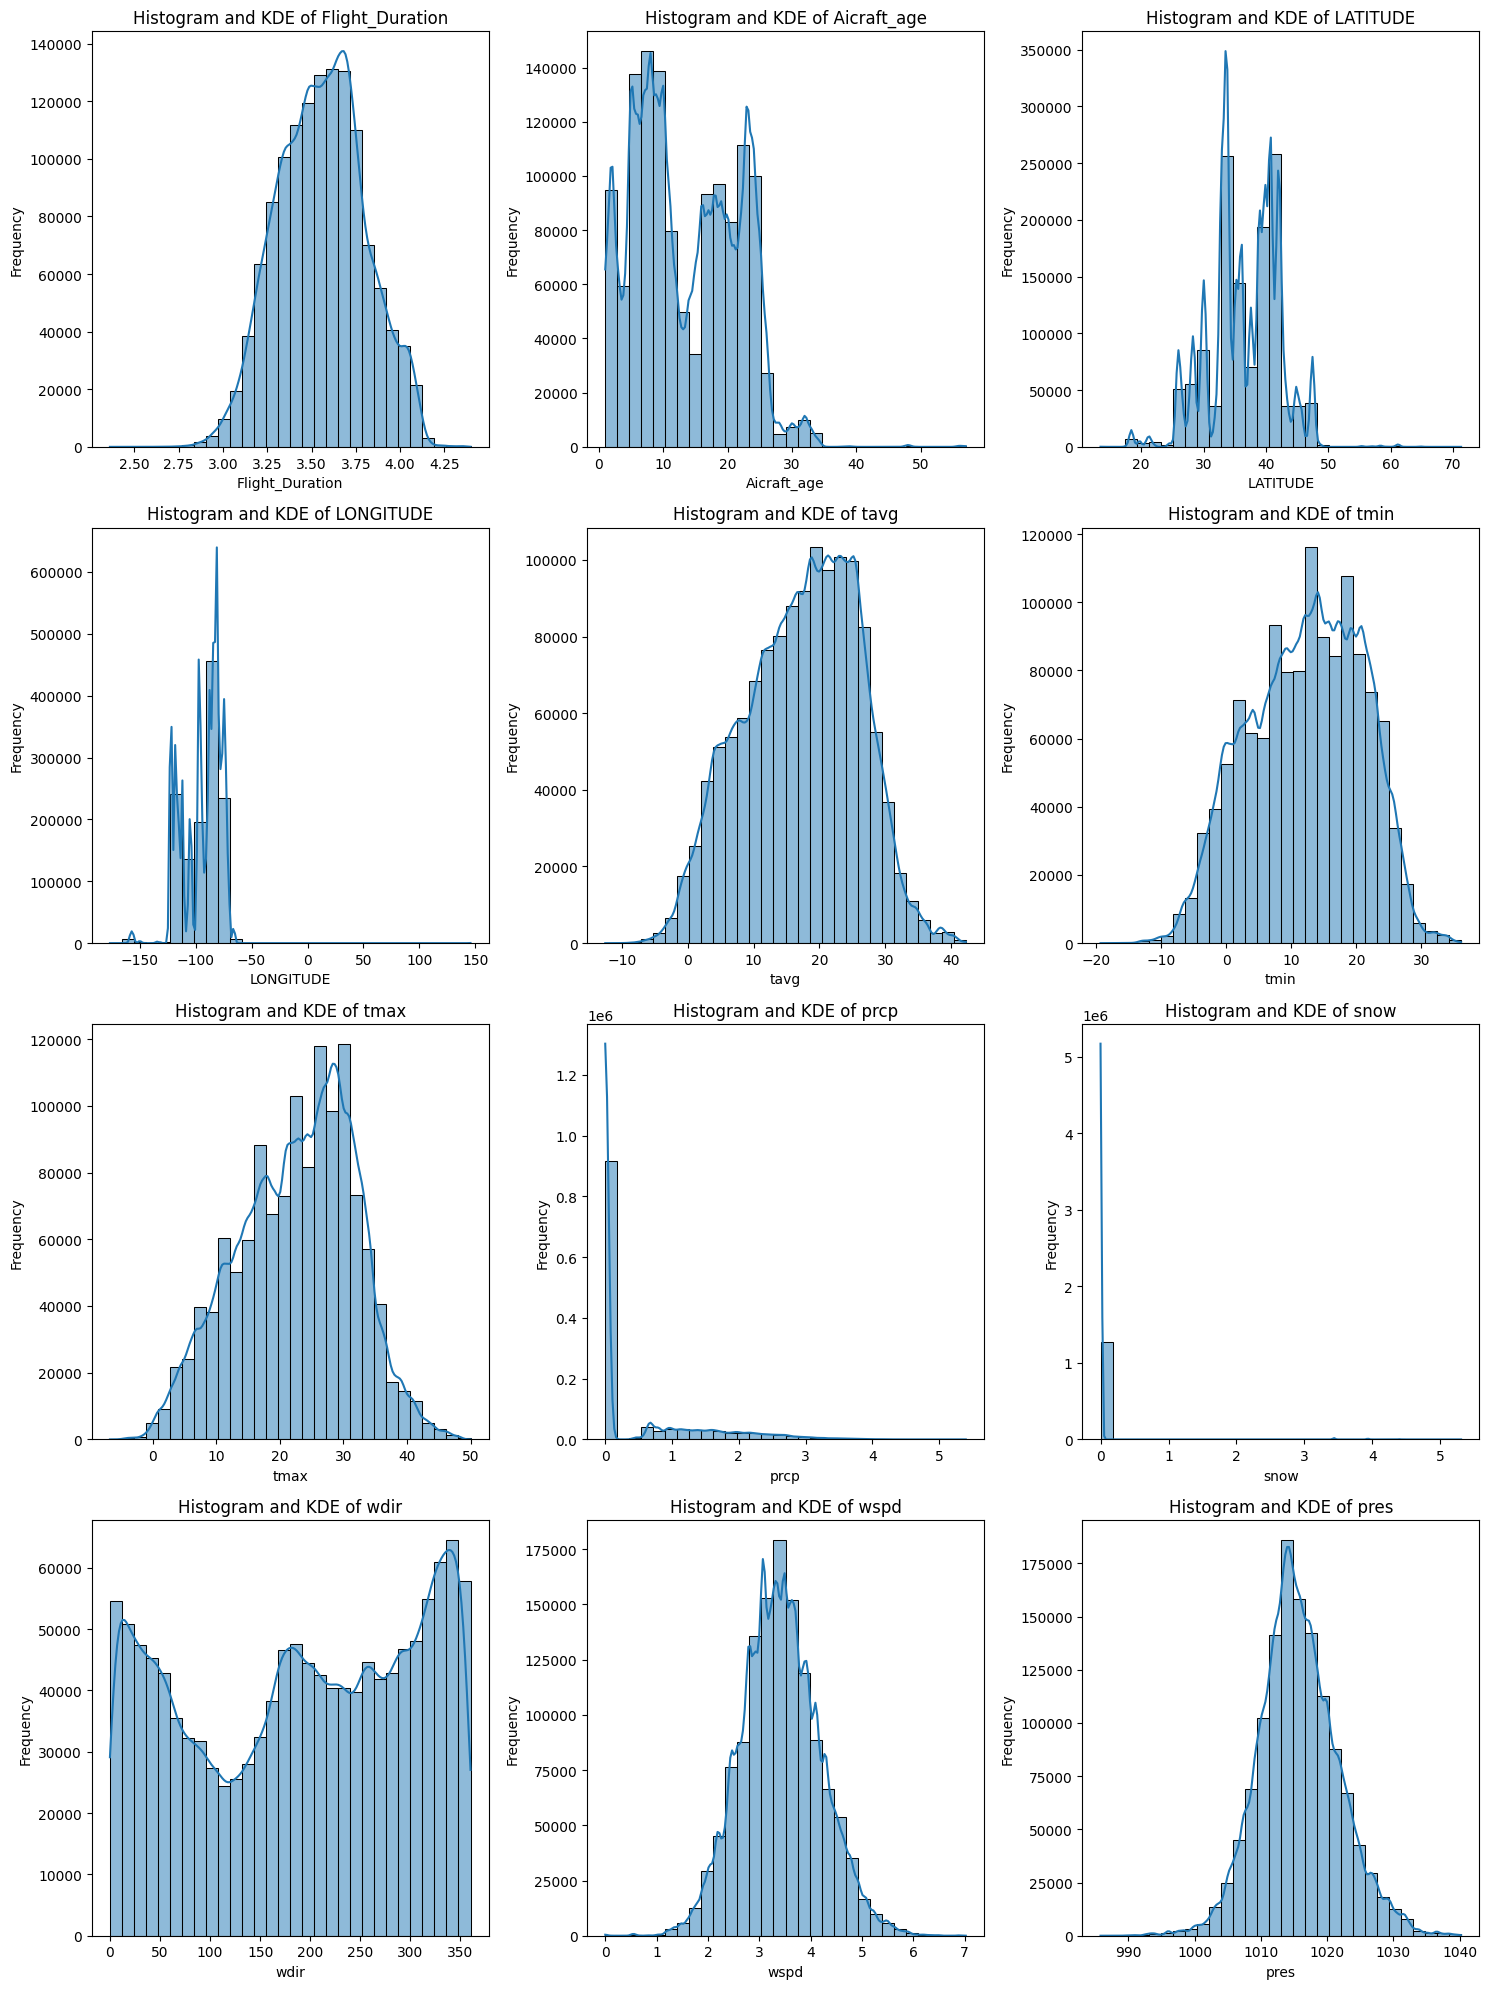

In [35]:
plot_histograms(train_encoded, features_hist)

Randomly reducing the train_set to 25% size for computational performance during the following modeling process.

In [43]:
# Random subsampling: reduces the training set size to 50%
from sklearn.utils import resample

train_set_subsampled = resample(train_encoded, replace=False, n_samples=int(len(train_set) * 0.25), random_state=42)

print("Original train_set size:", len(train_set))
print("Train_set size after subsampling:", len(train_set_subsampled))

Original train_set size: 1348509
Train_set size after subsampling: 337127


In [44]:
train_set_subsampled.sample(2)

,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Dep_Delay_Tag,Airline_te,Tail_Number_te,Dep_Airport_te,DepTime_label_te,Arr_Airport_te,Distance_type_te,Manufacturer_te,Model_te
3709170,3,3.419044,16,36.89461,-76.20122,27.6,23.9,31.1,1.529097,0.0,235.0,3.391165,1016.0,7,19,0,0.179007,0.246246,0.322918,0.430252,0.385202,0.005526,5.309660,0.668844
5389904,1,3.323981,9,41.97960,-87.90446,4.1,-0.5,6.7,0.000000,0.0,285.0,3.741657,1022.4,10,30,1,0.242836,0.333396,0.365276,0.484976,0.264060,0.005526,5.312332,0.670034


In [ ]:
# Dividing X and y, train and test
X_train_encoded = train_set_subsampled[features_num + encoded_columns].copy()
X_test_encoded = test_encoded[features_num + encoded_columns].copy()
y_train = train_set_subsampled[target_reg]
y_test = test_encoded[target_reg]

#Resetting the index of all DataFrames to prevent misalignment
X_train_encoded = X_train_encoded.reset_index(drop=True)
X_test_encoded = X_test_encoded.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


print("X_train_encoded:", X_train_encoded.shape)
print("y_train:", y_train.shape)

print("\nX_test_encoded:", X_test_encoded.shape)
print("y_test:",y_test.shape)

X_train_encoded: (337127, 23)
y_train: (337127,)

X_test_encoded: (320233, 23)
y_test: (320233,)


#### StandartScaling

The standardization of the DataFrame will be used for statistical tests and feature selection, as well as for scale-sensitive analyses.

In [46]:
X_train_scaled, X_test_scaled = scale_features(X_train_encoded, X_test_encoded)

In [47]:
X_train_scaled.sample()

,Day_Of_Week,Flight_Duration,Aicraft_age,LATITUDE,LONGITUDE,tavg,tmin,tmax,prcp,snow,wdir,wspd,pres,Month,Day,Airline_te,Tail_Number_te,Dep_Airport_te,DepTime_label_te,Arr_Airport_te,Distance_type_te,Manufacturer_te,Model_te
105518,0.50875,2.183511,-0.566292,1.637654,-1.692079,-0.8627,-0.517532,-0.909249,-0.62075,-0.077467,1.313278,-1.622503,2.161844,-0.798278,0.608727,1.119355,1.759702,-1.033193,-1.092892,1.108772,1.734723e-18,0.064225,4.677051


### Feature Selection with ANOVA e FSTS

Selection of variables with high statistical significance in relation to the target (p-value < 0.01)

In [48]:
# ANOVA

from sklearn.feature_selection import f_classif

# Perform ANOVA on training data
f_scores, p_values = f_classif(X_train_scaled, y_train)

# Store results in a DataFrame
anova_results = pd.DataFrame({"Feature": X_train_scaled.columns, "F-Score": f_scores, "p-value": p_values})

# Select features with p-value < 0.05
selected_features_anova = anova_results[anova_results["p-value"] < 0.01]["Feature"].tolist()

print("Selected Features after ANOVA:", selected_features_anova)

Selected Features after ANOVA: ['Day_Of_Week', 'Flight_Duration', 'Aicraft_age', 'LATITUDE', 'LONGITUDE', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'Month', 'Day', 'Airline_te', 'Tail_Number_te', 'Dep_Airport_te', 'DepTime_label_te', 'Arr_Airport_te', 'Manufacturer_te', 'Model_te']


c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [20] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\lucas\anaconda3\envs\GPU-TensorFlow\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Exclude highly correlated and redundant columns (corr > 0.7). 

To select which of the correlated columns will be kept, a correlation analysis with respect to the target will be performed to retain the variable most related to class 1.

In [45]:
# FSTS

# Compute the correlation matrix using ANOVA-selected features
corr_matrix = X_train_scaled[selected_features_anova].corr().abs()

# Calculate the correlation of each feature with the target variable
correlation_with_target = X_train_scaled[selected_features_anova].corrwith(y_train).abs()

# Initialize a list to store features to drop
to_drop = []

# Iterate through the correlation matrix to identify highly correlated features
upper = np.triu(corr_matrix, k=1)  # Upper triangle of the correlation matrix

for column in corr_matrix.columns:
    # Check if any other feature is highly correlated with the current column
    correlated_columns = corr_matrix.columns[upper[:, corr_matrix.columns.get_loc(column)] > 0.7]
    
    for correlated_column in correlated_columns:
        # Compare correlation with the target variable (y_train)
        if correlation_with_target[column] >= correlation_with_target[correlated_column]:
            # Drop the correlated column if the current column is more correlated with the target
            to_drop.append(correlated_column)
        else:
            # Otherwise, drop the current column
            to_drop.append(column)

# Remove duplicates from the list of features to drop
to_drop = list(set(to_drop))

# Print the features that are being dropped due to high correlation with each other
print("Features to be dropped due to high correlation:", to_drop)

# Final feature selection after FSTS, keeping the variables that are not dropped
selected_features_fsts = [f for f in selected_features_anova if f not in to_drop]

print("Selected Features after FSTS:", selected_features_fsts)


Features to be dropped due to high correlation: ['Model_te', 'tmax', 'Airline_te', 'tavg', 'Manufacturer_te']
Selected Features after FSTS: ['Day_Of_Week', 'Flight_Duration', 'Aicraft_age', 'LATITUDE', 'LONGITUDE', 'tmin', 'prcp', 'wspd', 'pres', 'Month', 'Day', 'Tail_Number_te', 'Dep_Airport_te', 'DepTime_label_te', 'Arr_Airport_te', 'Distance_type_te']


In [ ]:
# Applying selected features by ANOVA + FSTS in both scaled and not scaled Dataframes

X_train_selected = X_train_scaled[selected_features_fsts].copy()
X_test_selected = X_test_scaled[selected_features_fsts].copy()

X_train_encoded = X_train_encoded[selected_features_fsts].copy()
X_test_encoded = X_test_encoded[selected_features_fsts].copy()

| DataFrame |    Content   |
| --------- | ----------- |
| X_train_selected |  Scaled X_train with selected features   |
| X_test_selected |   Scaled X_test with selected features  |
|            |            |
| X_train_encoded |   Non-scaled X_train with the selected features    |
| X_test_encoded |    Non-scaled X_test with the selected features   |

### Clustering

The article below proposes a methodology using density-based clusters (DBSCAN) to subdivide the entire dataset into different data groups. After that, each group is trained with a specific machine-learning model for Delay prediction. However, in this study, there was no improvement in predictions when considering different groups via clustering with HDBSCAN, which also required significant computational capacity to form the clusters. Therefore, this approach was not followed, but it is referenced in the study as an interesting method that may be useful for other datasets with different data.

https://www.nature.com/articles/s41598-024-55217-z

----------------------------------------

### Models Baseline

Generating a classification report for a random classifier, i.e., one that follows only the probabilities according to the natural imbalance of the target. The models will be evaluated based on how they outperform a random classifier.

In [56]:
from sklearn.metrics import classification_report

# Conta a proporção real das classes no conjunto de treinamento
unique, counts = np.unique(y_train, return_counts=True)
class_proportions = counts / counts.sum()

# Gera previsões aleatórias seguindo a proporção das classes
y_pred_random = np.random.choice(unique, size=len(y_test), p=class_proportions)

# Avalia o desempenho do classificador aleatório
print("Random Classifier - Classification Report:")
print(classification_report(y_test, y_pred_random))

Random Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62    199735
           1       0.38      0.38      0.38    120498

    accuracy                           0.53    320233
   macro avg       0.50      0.50      0.50    320233
weighted avg       0.53      0.53      0.53    320233



### Models with standarized data

LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Creating and training the regression model
reg_model = LinearRegression()
reg_model.fit(X_train_resampled, y_train_resampled)

# Predictions on the training set
y_train_pred = reg_model.predict(X_train_resampled)
rmse_train = np.sqrt(mean_squared_error(y_train_resampled, y_train_pred))
r2_train = r2_score(y_train_resampled, y_train_pred)
print(f"RMSE (Train): {rmse_train:.4f}")
print(f"R² (Train): {r2_train:.4f}")

# Predictions on the test set
y_test_pred = reg_model.predict(X_test_selected)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)
print(f"RMSE (Test): {rmse_test:.4f}")
print(f"R² (Test): {r2_test:.4f}")
print("-" * 60)



              precision    recall  f1-score   support

           0       0.64      0.63      0.64    127239
           1       0.64      0.64      0.64    127239

    accuracy                           0.64    254478
   macro avg       0.64      0.64      0.64    254478
weighted avg       0.64      0.64      0.64    254478

              precision    recall  f1-score   support

           0       0.75      0.63      0.68    199735
           1       0.51      0.65      0.57    120498

    accuracy                           0.64    320233
   macro avg       0.63      0.64      0.63    320233
weighted avg       0.66      0.64      0.64    320233

------------------------------------------------------------


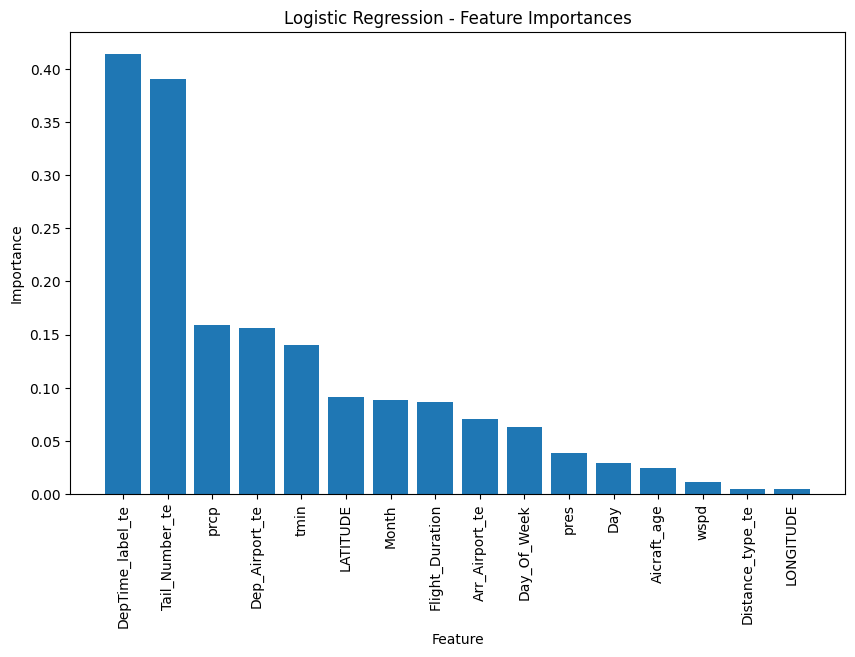

In [ ]:
plot_feature_importance_logistic(rl_model, X_train_resampled.columns, "Linear Regression")


### Models with non-standarized data (Bagging and Boosting models)

In [60]:
# RandomUndersampling of non-scaled dataframe

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Perform random undersampling on the training set
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_encoded, y_train)

# Print the shapes before and after
print(f"X_train_selected shape: {X_train_encoded.shape}")
print(f"X_train_resampled shape: {X_train_resampled.shape}")

X_train_selected shape: (337127, 16)
X_train_resampled shape: (254478, 16)


Performing models with defaul hyperparameters

Standarized data

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Defining models
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    # "GradientBoost": GradientBoostingRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42)
}

# Training and evaluating models
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)
    
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test_encoded)
    
    rmse_train = np.sqrt(mean_squared_error(y_train_resampled, y_train_pred))
    r2_train = r2_score(y_train_resampled, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    
    print(f"\n{model_name} - RMSE (Train): {rmse_train:.4f}")
    print(f"{model_name} - R² (Train): {r2_train:.4f}")
    print(f"{model_name} - RMSE (Test): {rmse_test:.4f}")
    print(f"{model_name} - R² (Test): {r2_test:.4f}")


Training RandomForest...

RandomForest - Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127239
           1       1.00      1.00      1.00    127239

    accuracy                           1.00    254478
   macro avg       1.00      1.00      1.00    254478
weighted avg       1.00      1.00      1.00    254478


RandomForest - Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71    199735
           1       0.54      0.61      0.57    120498

    accuracy                           0.65    320233
   macro avg       0.64      0.65      0.64    320233
weighted avg       0.67      0.65      0.66    320233


Training XGBoost...

XGBoost - Training Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70    127239
           1       0.70      0.66      0.68    127239



Non-standarized data

In [5]:
# Editar dataframes abaixo para encoded sem standarização

In [ ]:
# Training and evaluating models
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)
    
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test_encoded)
    
    rmse_train = np.sqrt(mean_squared_error(y_train_resampled, y_train_pred))
    r2_train = r2_score(y_train_resampled, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    
    print(f"\n{model_name} - RMSE (Train): {rmse_train:.4f}")
    print(f"{model_name} - R² (Train): {r2_train:.4f}")
    print(f"{model_name} - RMSE (Test): {rmse_test:.4f}")
    print(f"{model_name} - R² (Test): {r2_test:.4f}")

In [6]:
# Gerar tabela comparando classification report de ambos os testes. Decidir e explicar o porquê de não usar (ou usar) dados escalados ou não antes da busca por hiperparâmetros

Performing RandomizedSearchCV for each model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Defining hyperparameter grid
rf_params = {
    'n_estimators': np.arange(100, 500, 100),
    'max_depth': [5, 7, 10, 12, 15],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Initializing RandomForest Regressor
rf = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_params, scoring='neg_mean_squared_error', n_iter=20, cv=5, verbose=1, random_state=42, n_jobs=-1)
rf_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_random_rf = rf_search.best_estimator_
print("\nRandomForest - Best Estimator:\n", rf_search.best_params_)

# Predictions and evaluation
y_train_pred = best_random_rf.predict(X_train_resampled)
y_test_pred = best_random_rf.predict(X_test_encoded)

rmse_train = np.sqrt(mean_squared_error(y_train_resampled, y_train_pred))
r2_train = r2_score(y_train_resampled, y_train_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print(f"\nRandomForest - RMSE (Train): {rmse_train:.4f}")
print(f"RandomForest - R² (Train): {r2_train:.4f}")
print(f"RandomForest - RMSE (Test): {rmse_test:.4f}")
print(f"RandomForest - R² (Test): {r2_test:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

RandomForest - Best Estimator:
 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': False}

RandomForest - Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.79      0.83      0.81    127654
           1       0.82      0.78      0.80    127654

    accuracy                           0.80    255308
   macro avg       0.80      0.80      0.80    255308
weighted avg       0.80      0.80      0.80    255308


RandomForest - Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.74      0.69      0.71    209129
           1       0.55      0.62      0.58    128042

    accuracy                           0.66    337171
   macro avg       0.65      0.65      0.65    337171
weighted avg       0.67      0.66      0.66    337171



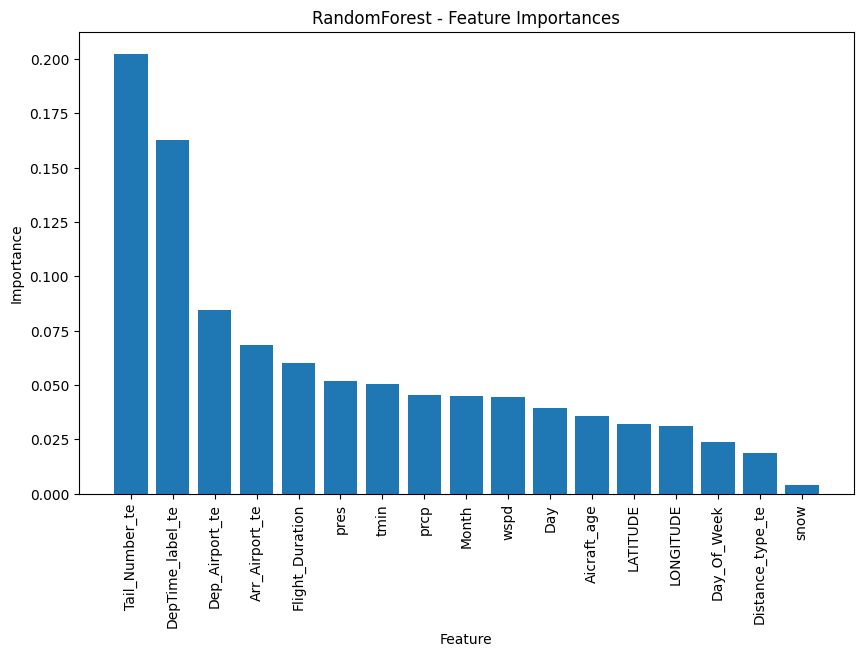

In [47]:
# Feature Importance for RandomForest
plot_feature_importance(best_random_rf, X_train_resampled.columns, "RandomForest")

In [48]:
y_pred_proba_rf = best_random_rf.predict_proba(X_test_encoded)[:, 1]
high_confidence_rf = y_pred_proba_rf > 0.9

y_pred_rf = best_random_rf.predict(X_test_encoded)
true_positives_rf = ((y_pred_rf == 1) & (y_test == 1) & high_confidence_rf).sum()
total_high_confidence_rf = high_confidence_rf.sum()

percentage_rf = (true_positives_rf / total_high_confidence_rf) * 100 if total_high_confidence_rf > 0 else 0
print(f"Random Forest - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_rf:.2f}%")


Random Forest - Percentage of True Positives (Class 1) with >90% Confidence: 89.12%


In [63]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search for XGBoost
xgb_params = {
    'n_estimators': np.arange(50, 450, 50),
    'max_depth': np.arange(3, 15, 2),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_params, scoring='f1', n_iter=20, cv=5, verbose=1, random_state=42, n_jobs=-1)
xgb_search.fit(X_train_resampled, y_train_resampled)
best_random_xg = xgb_search.best_estimator_
print("\nXGBoost - Best Estimator:\n", xgb_search.best_params_)
print("\nXGBoost - Best Model Classification Report (Train):\n", classification_report(y_train_resampled, best_random_xg.predict(X_train_resampled)))
print("\nXGBoost - Best Model Classification Report (Test):\n", classification_report(y_test, best_random_xg.predict(X_test_encoded)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits

XGBoost - Best Estimator:
 {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.07444444444444444, 'colsample_bytree': 0.9}

XGBoost - Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.69      0.73      0.71    127239
           1       0.72      0.68      0.70    127239

    accuracy                           0.71    254478
   macro avg       0.71      0.71      0.70    254478
weighted avg       0.71      0.71      0.70    254478


XGBoost - Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.76      0.69      0.72    199735
           1       0.55      0.63      0.59    120498

    accuracy                           0.67    320233
   macro avg       0.65      0.66      0.65    320233
weighted avg       0.68      0.67      0.67    320233



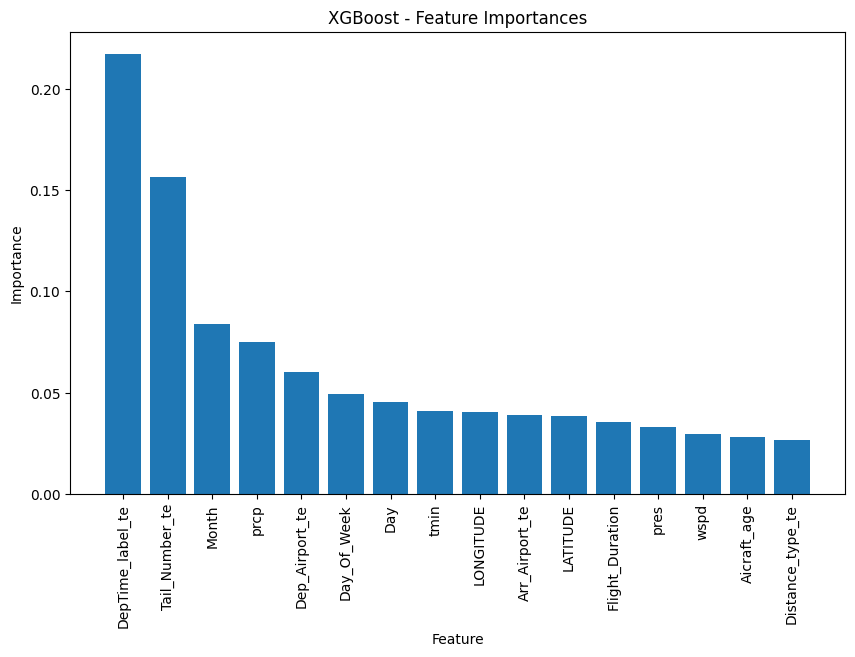

In [64]:
plot_feature_importance(best_random_xg, X_train_resampled.columns, "XGBoost")

In [65]:
y_pred_proba_xg = best_random_xg.predict_proba(X_test_encoded)[:, 1]
high_confidence_xg = y_pred_proba_xg > 0.90

y_pred_xg = best_random_xg.predict(X_test_encoded)
true_positives_xg = ((y_pred_xg == 1) & (y_test == 1) & high_confidence_xg).sum()
total_high_confidence_xg = high_confidence_xg.sum()

percentage_xg = (true_positives_xg / total_high_confidence_xg) * 100 if total_high_confidence_xg > 0 else 0
print(f"XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_xg:.2f}%")


XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: 89.23%


In [52]:
import warnings
warnings.filterwarnings("ignore")

sys.stderr = open(os.devnull, "w")

# Randomized Search for LightGBM
lgbm_params = {
    'n_estimators': np.arange(50, 450, 100),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 15, 2),
    'num_leaves': np.arange(20, 150, 10),
    'subsample': [0.5, 0.6, 0.7, 0.8]
}
lgbm = LGBMClassifier(random_state=42)
lgbm_search = RandomizedSearchCV(lgbm, lgbm_params, scoring='f1', n_iter=20, cv=5, verbose=0, random_state=42, n_jobs=-1)
lgbm_search.fit(X_train_resampled, y_train_resampled)
best_random_gbm = lgbm_search.best_estimator_
print("\LightGBM - Best Estimator:\n", lgbm_search.best_params_)

print("\nLightGBM - Best Model Classification Report (Train):\n", classification_report(y_train_resampled, best_random_gbm.predict(X_train_resampled)))
print("\nLightGBM - Best Model Classification Report (Test):\n", classification_report(y_test, best_random_gbm.predict(X_test_encoded)))

[LightGBM] [Info] Number of positive: 127654, number of negative: 127654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 255308, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

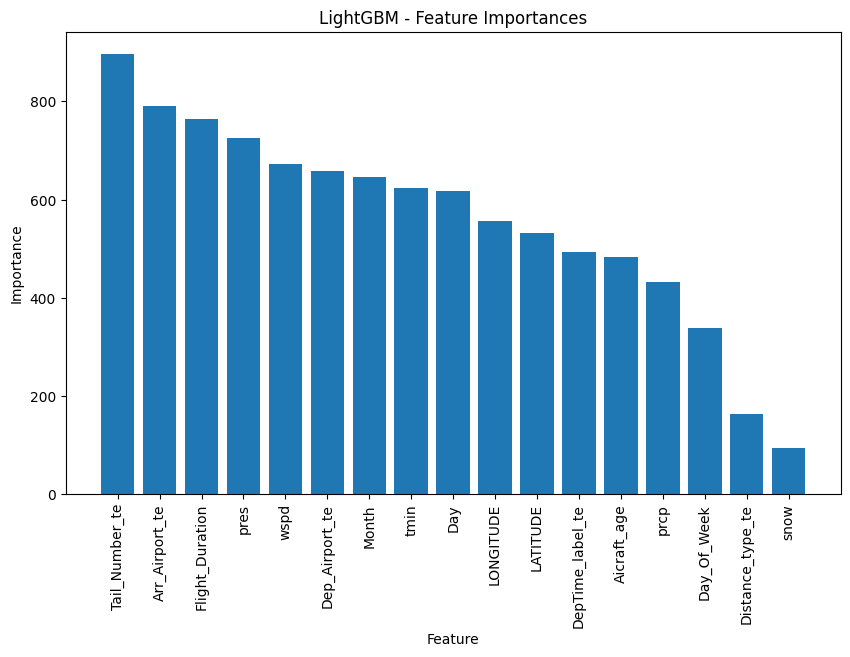

In [53]:
plot_feature_importance(best_random_gbm, X_train_resampled.columns, "LightGBM")

In [54]:
y_pred_proba_gbm = best_random_gbm.predict_proba(X_test_encoded)[:, 1]
high_confidence_gbm = y_pred_proba_gbm > 0.9

y_pred_gbm = best_random_gbm.predict(X_test_encoded)
true_positives_gbm = ((y_pred_gbm == 1) & (y_test == 1) & high_confidence_gbm).sum()
total_high_confidence_gbm = high_confidence_gbm.sum()

percentage_gbm = (true_positives_gbm / total_high_confidence_gbm) * 100 if total_high_confidence_gbm > 0 else 0
print(f"LightGBM - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_gbm:.2f}%")


LightGBM - Percentage of True Positives (Class 1) with >90% Confidence: 87.91%


In [ ]:
# Gerar tabela comparando o rendimento de cada modelo.

### Fine-Tuning and Hiperparams Search

XGBClassifier

In [66]:
# Define the objective function for optimization
def objective(params):
    # Initialize the XGBoost classifier with GPU settings
    xgb = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='gpu_hist',  # Enable GPU acceleration
        gpu_id=0,  # Use the first GPU
        n_jobs=-1  # Utilize all available CPU cores for pre-processing
    )
    
    # Train the model
    xgb.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions
    y_pred_test = xgb.predict(X_test_encoded)
    
    # Compute the F1 score on the test set
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Hyperopt minimizes the objective function, so we return the negative F1 score
    return {'loss': -test_f1, 'status': 'ok'}


In [67]:
best_random_xg.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07444444444444444, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)>

In [69]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier

# Define the hyperparameter search space
space = {
    'n_estimators': hp.quniform('n_estimators', 275, 325, 5),
    'max_depth': hp.quniform('max_depth', 5, 10, 0.5),
    'learning_rate': hp.quniform('learning_rate', 0.05, 0.1, 0.001),
    'subsample': hp.choice('subsample', [0.8, 0.85, 0.9, 0.95, 1]),  
    'colsample_bytree': hp.choice('colsample_bytree', [0.8, 0.85, 0.9, 0.95, 1])  
}

# Define the objective function with cross-validation
def objective(params):
    model = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='gpu_hist',
        gpu_id=0,
        n_jobs=-1
    )

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Compute mean F1-score across all folds
    f1 = cross_val_score(model, X_train_resampled, y_train_resampled, cv=skf, scoring=make_scorer(f1_score)).mean()

    # Hyperopt minimizes the objective, so return the negative F1-score
    return -f1

# Initialize trials object to track results
trials = Trials()

# Random number generator
rstate = np.random.default_rng(42)

# Run optimization using Tree-structured Parzen Estimator (TPE)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rstate)

# Print the best hyperparameters found by Hyperopt
print("\nBest Hyperparameters found by Hyperopt:")
print(best)

# Train the best model with the selected hyperparameters
best_model_xgb = XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=[0.8, 0.85, 0.9, 0.95, 1][best['subsample']],
    colsample_bytree=[0.8, 0.85, 0.9, 0.95, 1][best['colsample_bytree']], 
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    tree_method='gpu_hist',
    gpu_id=0,
    n_jobs=-1
)

# Train the best model on the full training set
best_model_xgb.fit(X_train_resampled, y_train_resampled)

# Make predictions on training and testing sets
y_pred_train_best = best_model_xgb.predict(X_train_resampled)
y_pred_test_best = best_model_xgb.predict(X_test_encoded)

# Print the classification report for the training set
print("\nBest Model Classification Report (Train):\n", classification_report(y_train_resampled, y_pred_train_best))

# Print the classification report for the test set
print("\nBest Model Classification Report (Test):\n", classification_report(y_test, y_pred_test_best))


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [09:13<00:00, 11.06s/trial, best loss: -0.6480438318649245]

Best Hyperparameters found by Hyperopt:
{'colsample_bytree': 0, 'learning_rate': 0.064, 'max_depth': 8.0, 'n_estimators': 275.0, 'subsample': 1}

Best Model Classification Report (Train):
               precision    recall  f1-score   support

           0       0.71      0.75      0.73    127239
           1       0.73      0.69      0.71    127239

    accuracy                           0.72    254478
   macro avg       0.72      0.72      0.72    254478
weighted avg       0.72      0.72      0.72    254478


Best Model Classification Report (Test):
               precision    recall  f1-score   support

           0       0.76      0.69      0.72    199735
           1       0.55      0.63      0.59    120498

    accuracy                           0.67    320233
   macro avg       0.65      0.66      0.65    320233
weighted avg       0.68      0.67      0.67    320233



In [70]:
y_pred_proba_xg = best_model_xgb.predict_proba(X_test_encoded)[:, 1]
high_confidence_xg = y_pred_proba_xg > 0.90

y_pred_xg = best_model_xgb.predict(X_test_encoded)
true_positives_xg = ((y_pred_xg == 1) & (y_test == 1) & high_confidence_xg).sum()
total_high_confidence_xg = high_confidence_xg.sum()

percentage_xg = (true_positives_xg / total_high_confidence_xg) * 100 if total_high_confidence_xg > 0 else 0
print(f"XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: {percentage_xg:.2f}%")


XGBoost - Percentage of True Positives (Class 1) with >90% Confidence: 88.00%


In [ ]:
# plotar matriz de confusão, curva ROC, AUC e todas as métricas de avaliação do melhor modelo

In [ ]:
# Conclusão do trabalho